In [1]:
import yfinance as yf
import pandas as pd
import zipfile
import json
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import pickle
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pickle
from collections import defaultdict

In [36]:
# Set directory and device
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# set directory for data and model
data_dir = 'dataset/'
model_dir = 'model/'


Device: cuda


## Model and Dataset Classes

In [37]:
# dataset class
class StockPriceDataset(Dataset):
    def __init__(self, data, window_size, output_dim):
        self.window_size = window_size
        self.data = data
        self.output_dim = output_dim
        self.normalize()
        self.sequenced_data = self.sequence_data()

    def normalize(self):
        
        # normalize data
        self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].min()) / (self.data["daily_return"].max() - self.data["daily_return"].min() + 1e-8)
        self.data["sentiment"] = (self.data["sentiment"] - self.data["sentiment"].min()) / (self.data["sentiment"].max() - self.data["sentiment"].min() + 1e-8)
        self.data["sentiment_company"] = (self.data["sentiment_company"] - self.data["sentiment_company"].min()) / (self.data["sentiment_company"].max() - self.data["sentiment_company"].min() + 1e-8)
        self.data["sentiment_industry"] = (self.data["sentiment_industry"] - self.data["sentiment_industry"].min()) / (self.data["sentiment_industry"].max() - self.data["sentiment_industry"].min() + 1e-8)

    # create sequences by seperating each month data into seperate sequence
    def sequence_data(self):
        data = self.data
        list_of_df = []
        temp = data.copy()
        temp = temp.reset_index()
        temp["Date"] = pd.to_datetime(temp["Date"])
        all_available_dates = temp["Date"].unique()
    
        for i in range(len(all_available_dates)):
            date = all_available_dates[i]
            temp_df = data[data.index == date]
            list_of_df.append(temp_df)
        return list_of_df
        

    def __len__(self):
        return len(self.sequenced_data) - self.window_size - self.output_dim + 1

    def __getitem__(self, idx):
        if self.window_size == 1:
            sequences = self.sequenced_data[idx]
            data = sequences
        else:
            sequences = self.sequenced_data[idx: idx + self.window_size]
            data = pd.concat(sequences, axis=0)
            # data = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq.values).float() for seq in sequences], batch_first=True)
        x = data.iloc[:, :].values
        # x = data
        if self.window_size == 1:
            sequences_output = self.sequenced_data[idx: idx + self.output_dim]
            data_output = sequences_output[0]
        else:
            sequences_output = self.sequenced_data[idx : idx + self.window_size + self.output_dim]
            data_output = pd.concat(sequences_output, axis=0)
        y = data_output.iloc[-self.output_dim:, -1:].values
        return torch.tensor(x).float().to(device), torch.tensor(y).float().to(device)
        # return x.to(device), torch.tensor(y).float().to(device)
    
    def return_sequences(self, idx):
        return self.sequenced_data[idx: idx+1]

In [38]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=2, kernel_size=3, stride=1)
        if num_layers == 1:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        else:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        
        _, (hidden_n, _) = self.lstm(x)
        
        out = self.fc(hidden_n[-1, :, :])

        return out 

## Loading Dataset and Trained Model

In [64]:
# Hyperparameters
input_dim = 4 # number of features
hidden_dim = 20 # number of hidden units
num_layers = 2 # number of LSTM layers
output_dims = [30,90,180,360] # predict next specified days of stock price
batch_size = 32 # number of samples in each batch

In [67]:
# evaluate trained models on test dataset and calculate RMSE

selected_companies = ['GOOGL', 'META', 'BIDU']
data_pred = {}
data_act = {}
data_rmse = {}

for company in selected_companies:
    for output_dim in output_dims:
        
        # load test dataset
        test_dataset_name = 'test_dataset-'
        company_name = company + '-'
        prediction_days = output_dim.__str__() + '-'
        path = data_dir + test_dataset_name + company_name + prediction_days + '.pkl'
        with open(path, 'rb') as f:
            test = pickle.load(f)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

        # load trained model
        model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
        criterion = nn.HuberLoss()

        model_name = 'lstm-'
        company_name = company + '-'
        prediction_days = output_dim.__str__() + '-'
        path = model_dir + model_name + company_name + prediction_days + '.pth'
        model.load_state_dict(torch.load(path))

        # evaluation on test data
        model.eval()
        test_loss = 0.0
        num_test_batches = 0
        actual_values = []
        predicted_values = []

        with torch.no_grad():
            for batch in test_loader:
                inputs, targets = batch
                targets = targets.squeeze(-1) # remove last dimension

                output = model(inputs)
                loss = criterion(output, targets)
                
                test_loss += loss.item()
                num_test_batches += 1

                # Record actual and predicted values
                actual_values.extend(targets.tolist())
                predicted_values.extend(output.tolist())

        test_loss /= num_test_batches
        
        print(path)
        print('Test Loss: {:.6f}'.format(test_loss))
        print(actual_values[0:5])
        print(predicted_values[0:5])

        # save actual and predicted values in dictionary
        data_pred[company + '-' + output_dim.__str__()] = predicted_values[0] 
        data_act[company + '-' + output_dim.__str__()] = actual_values[0]

        # root mean squared error
        rmse = mean_squared_error(actual_values, predicted_values, squared=False)
        data_rmse[company + '-' + output_dim.__str__()] = rmse
        print('RMSE: {:.6f}'.format(rmse))


model/lstm-GOOGL-30-.pth
Test Loss: 0.042708
[[0.5171769261360168, 0.5317903161048889, 0.5958304405212402, 0.4930810034275055, 0.6251768469810486, 0.5776870250701904, 0.5493475794792175, 0.5719471573829651, 0.557648777961731, 0.5583918690681458, 0.5470151901245117, 0.5501469969749451, 0.5712454915046692, 0.6673681735992432, 0.5929790735244751, 0.5680973529815674, 0.5031535029411316, 0.5754942893981934, 0.6129221320152283, 0.571124255657196, 0.5910034775733948, 0.511294424533844, 0.5559964776039124, 0.46707063913345337, 0.6200518608093262, 0.6081578731536865, 0.5900844931602478, 0.728662371635437, 0.5940504670143127, 0.48101216554641724], [0.5317903161048889, 0.5958304405212402, 0.4930810034275055, 0.6251768469810486, 0.5776870250701904, 0.5493475794792175, 0.5719471573829651, 0.557648777961731, 0.5583918690681458, 0.5470151901245117, 0.5501469969749451, 0.5712454915046692, 0.6673681735992432, 0.5929790735244751, 0.5680973529815674, 0.5031535029411316, 0.5754942893981934, 0.612922132015

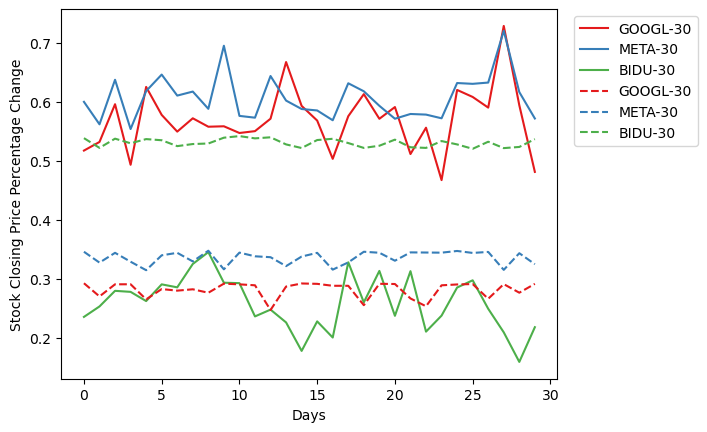

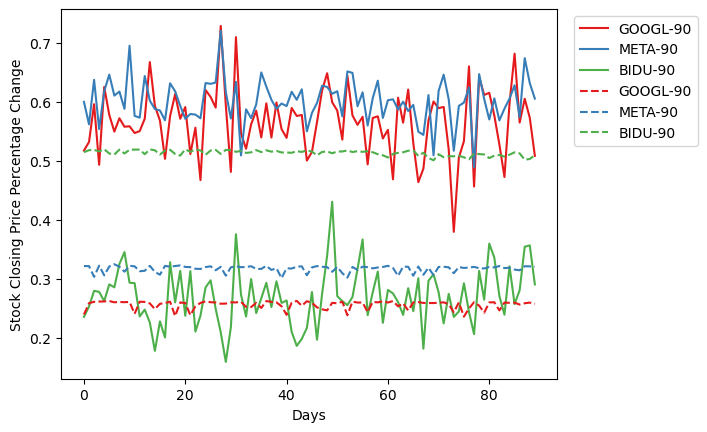

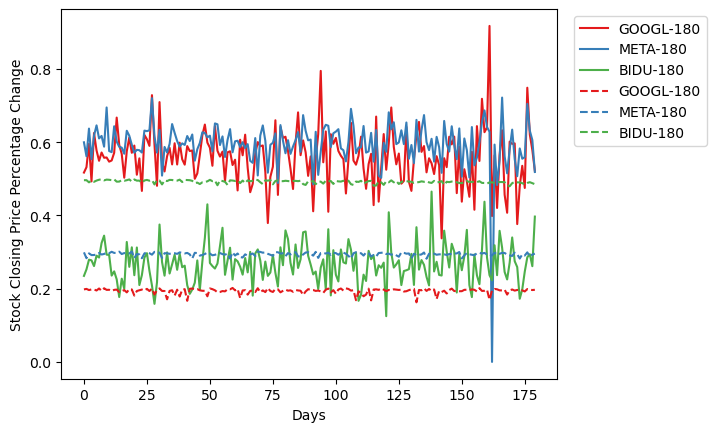

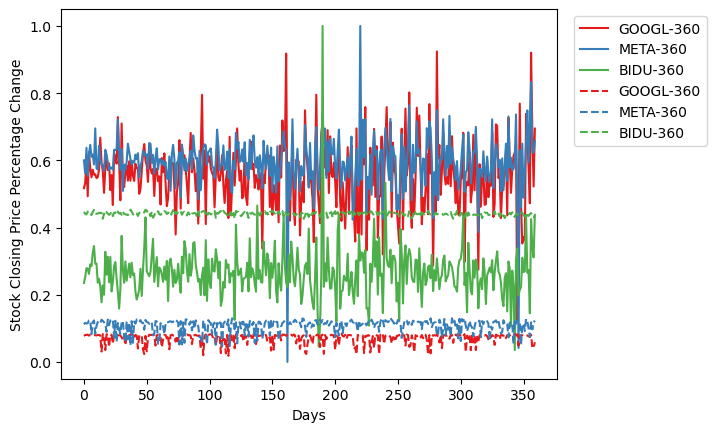

In [66]:
# plot actual and predicted values for each company and each output dimension
temp_dict = defaultdict(dict)
for key, values in data_act.items():
    temp_dict[len(values)][key] = values
data_act_sorted = dict(temp_dict)

temp_dict = defaultdict(dict)
for key, values in data_pred.items():
    temp_dict[len(values)][key] = values
data_pred_sorted = dict(temp_dict)

for output_dim in output_dims:
    temp_act = data_act_sorted[output_dim]
    temp_pred = data_pred_sorted[output_dim]

    df_pred = pd.DataFrame(temp_pred)
    df_act = pd.DataFrame(temp_act)

    actual_palette = sns.color_palette("Set1", n_colors=len(df_act.columns))
    predicted_palette = sns.color_palette("Set1", n_colors=len(df_pred.columns))

    lines = []  # store line instances for the legend

    for i, column in enumerate(df_act.columns):
        line, = plt.plot(df_act[column], color=actual_palette[i], linestyle='-')
        lines.append(line)

    for i, column in enumerate(df_pred.columns):
        line, = plt.plot(df_pred[column], color=predicted_palette[i], linestyle='--')
        lines.append(line)

    # specify legend
    labels = df_act.columns.tolist() + df_pred.columns.tolist()
    plt.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc='upper left')

    # specify axis labels
    plt.xlabel('Days')
    plt.ylabel('Stock Closing Price Percentage Change')
    plt.show()

In [4]:
#  print actual and predicted RMSE for each company and each output dimension
for key, value in data_rmse.items():
    print(f"{key}: {value}")

GOOGL-30: 0.2920385856623669
GOOGL-90: 0.3150042450804335
GOOGL-180: 0.37365801661149967
GOOGL-360: 0.49394637763618854
META-30: 0.2708759755910065
META-90: 0.2879567858906787
META-180: 0.31002441250138696
META-360: 0.4921107653776275
BIDU-30: 0.2727146080195861
BIDU-90: 0.25656762147791334
BIDU-180: 0.23847616893205448
BIDU-360: 0.18773066878453912
